## 次元削減，特徴量抽出，多様体学習

教師無し学習を用いたデータ変換には，可視化，データの圧縮，表現の発見が挙げられる．
それらを目的として最も用いられるアルゴリズム

- 主成分分析(Principal Component Analysis: PCA)
- 非負値行列因子分解(Non-Negative Matriz Factorization: NMF)
    - 特徴量抽出
- t-SNE
    - 二次元散布図を用いたデータの可視化

### 主成分分析(PCA)

PCAはデータセットの特徴量を相互に統計的に関連しないように回転させる手法である．
多くの場合回転した後の特徴量から，データの説明に重要な一部の特徴量だけを抜き出す．

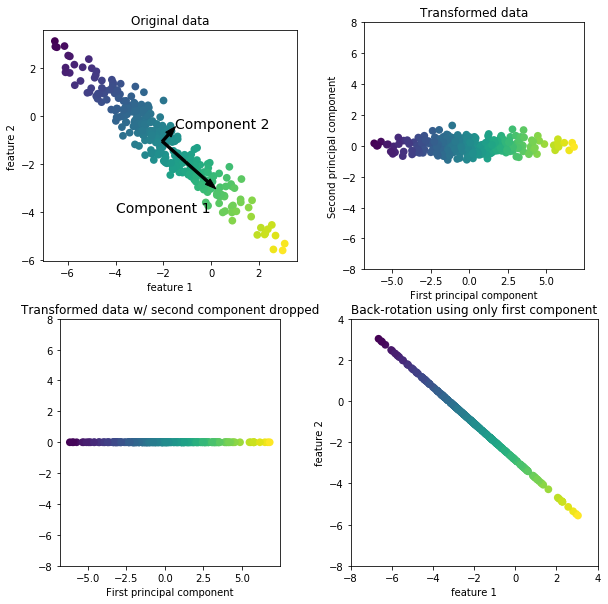

In [2]:
import mglearn
import matplotlib.pyplot as plt
%matplotlib inline
mglearn.plots.plot_pca_illustration()
plt.show()

最も分散が大きい方向を「第一成分」，第一成分に直交し，最も情報を持っている成分を「第二成分」とする．

「方向」を`主成分`と呼ぶ．元の特徴量の数=主成分    

右上の図は回転させたもの。原点の周辺にデータが来るように回転させる前にデータから平均値を引いてある。    
PCAで見つかった回転後の表現では２つの軸の相関はない。つまり表現でのデータの相関行列は対角成分を除いてゼロ。    

主成分のいくつかだけ残すことでPCAを次元削減に使える。左下の図では１つだけの成分を残した。    
２次元のデータを１次元に削減しても方向は維持されている。右下の図のように逆回転をして平均を足すと元に戻せる。    
直行した第二成分が消えている。データからノイズを除去したり、主成分で維持された情報を可視化するのに用いられる。

#### cancerデータセットのPCAによる可視化

特徴量が多くなるとペアプロットが多くなってしまう。下記の場合は４００程。    
特徴量ごとに２つのクラスのヒストグラムを見ると、どの特徴量が使えそうかわかる。    
smoothness errorのヒストグラムは重なってるのであまり情報がない。    
worst concave pointsのヒストグラムは重なっていないので情報が多い。    
しかしこのプロットを見てもここの特徴量の相関やクラス分類に与える影響は何もわからない。    
PCAを使えば主な相関を捉えれる。

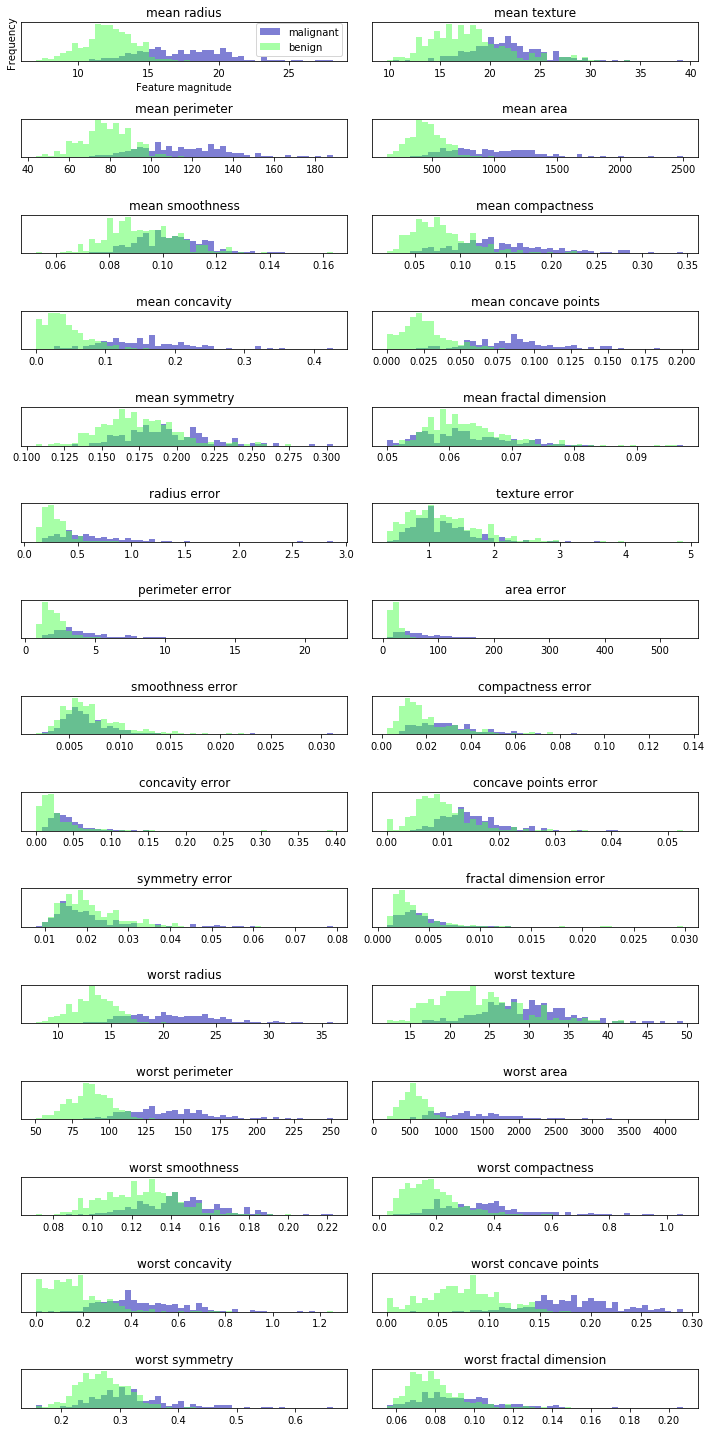

In [3]:
from sklearn.datasets import load_breast_cancer
import numpy as np
cancer = load_breast_cancer()

fig, axes = plt.subplots(15, 2, figsize=(10, 20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]

ax = axes.ravel()

# TODO: これ凄く使えそう(一般化したい)
for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["malignant", "benign"], loc="best")
fig.tight_layout()

plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# PCAを使う前にスケール変換する必要がある
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

In [5]:
from sklearn.decomposition import PCA

# 特徴を最初の2つの主成分だけにする
pca = PCA(n_components=2)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (569, 30)
Reduced shape: (569, 2)


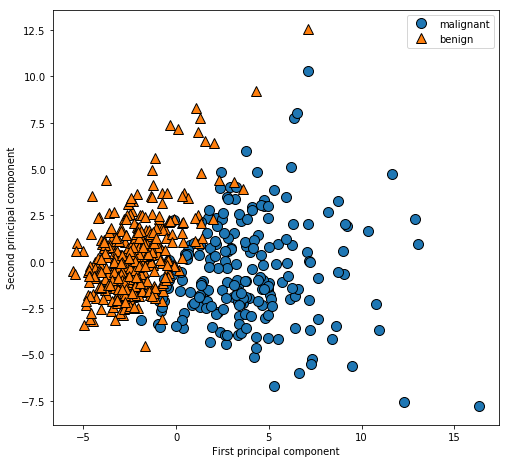

In [6]:
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

この状態になれば線形関数でもある程度分離できる。PCAの欠点はプロットした２つの軸の解釈が難しいこと。    
主成分はPCAの適合をおこなう過程でcomponents_属性に格納される。    
行が１つの主成分に対応する。

In [8]:
print("PCA component shape: {}".format(pca.components_.shape))

PCA component shape: (2, 30)


In [9]:
print("PCA components:\n{}".format(pca.components_))

PCA components:
[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


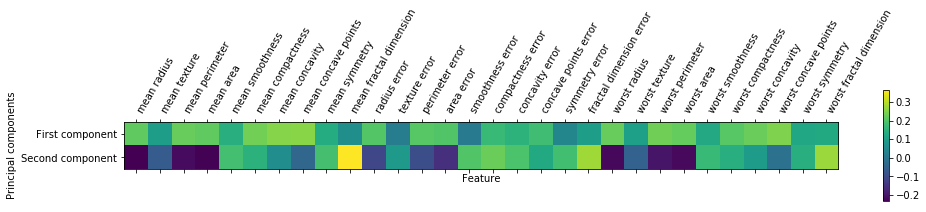

In [10]:
#第一主成分は全て似た色になってる。相関がある状態。
# 二つの主成分は両方とも30つの特徴量が入り混じっており，説明が出来ない
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)), cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")
plt.show()

#### 固有顔による特徴量抽出

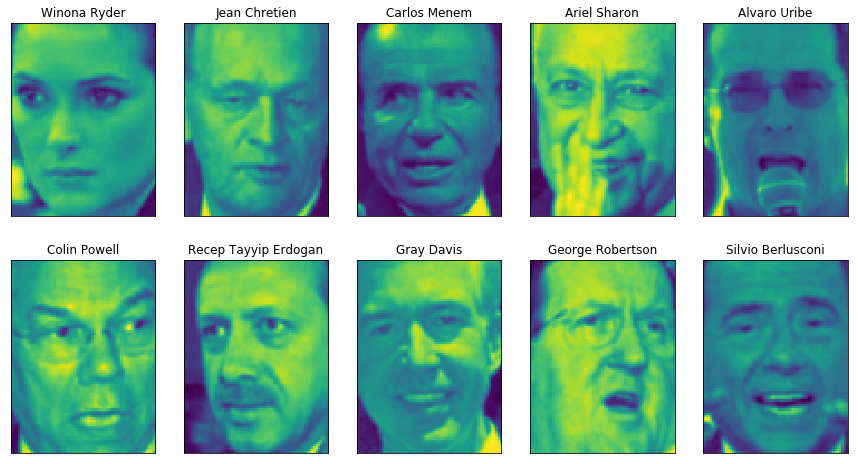

In [23]:
#ここから
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])
    
plt.show()

In [24]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


In [25]:
counts = np.bincount(people.target)

for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

In [28]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# 完全な白黒画像にする
X_people = X_people / 255.

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.23


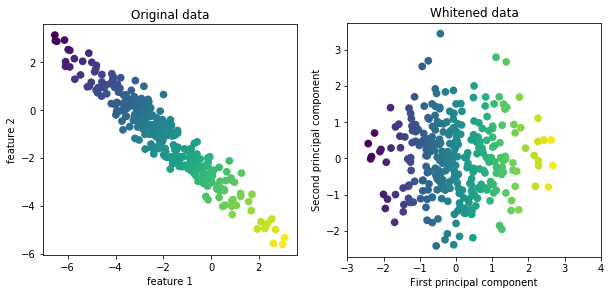

In [31]:
mglearn.plots.plot_pca_whitening()
plt.show()

In [32]:
# whiten=TrueをつけるとPCA後にStanderScalerを行うのと同じ意味を持つ
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1547, 100)


In [33]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.31


In [34]:
print("pca.components_.shape: {}".format(pca.components_.shape))

pca.components_.shape: (100, 5655)


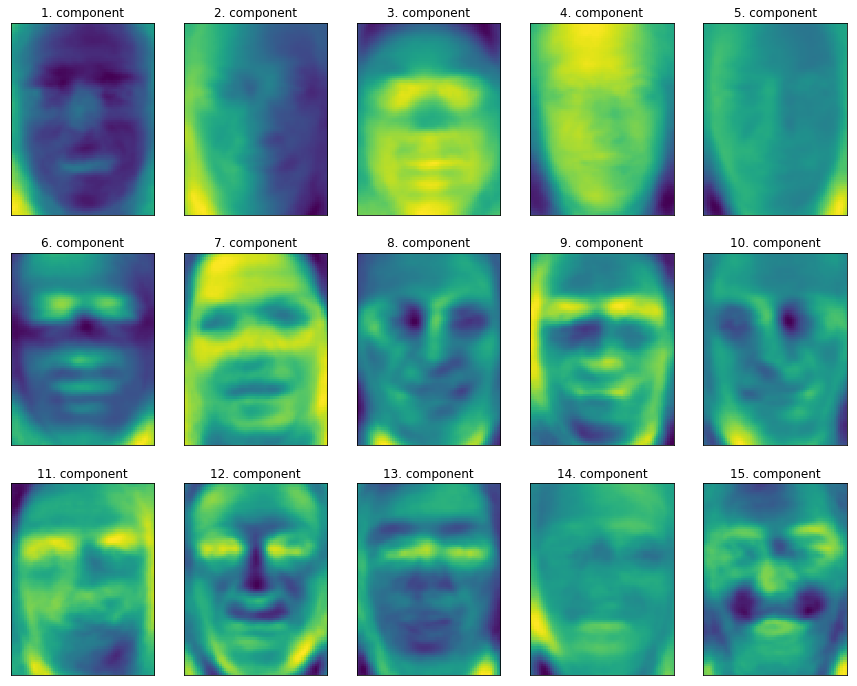

In [37]:
fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape),
              cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))
    
plt.show()

________________________________________________________________________________
[Memory] Calling mglearn.plot_pca.pca_faces...
pca_faces(array([[ 0.535948, ...,  0.243137],
       ..., 
       [ 0.043137, ...,  0.596078]], dtype=float32), 
array([[ 0.237908, ...,  0.269281],
       ..., 
       [ 0.4     , ...,  0.254902]], dtype=float32))
________________________________________________________pca_faces - 7.2s, 0.1min


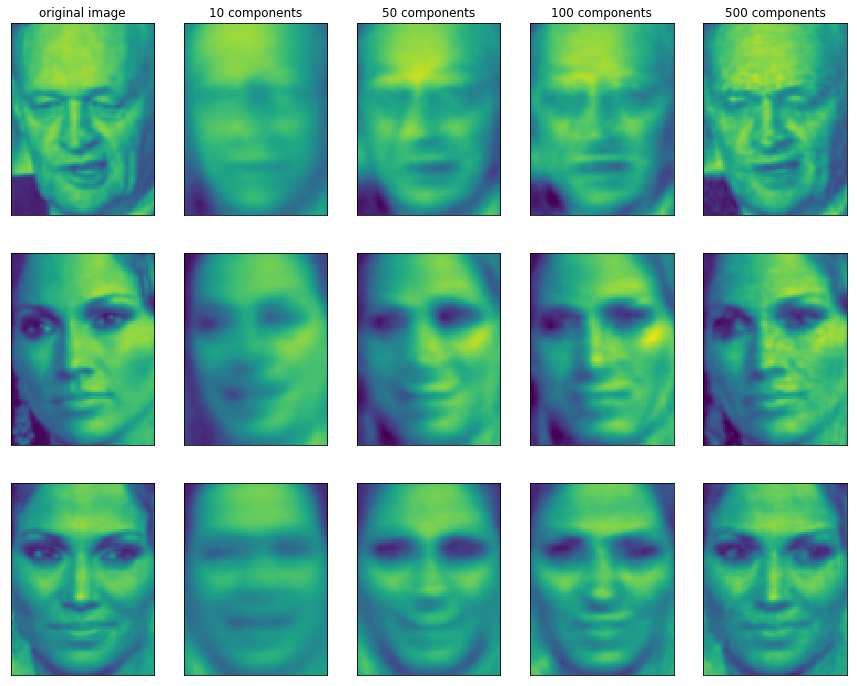

In [38]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)
plt.show()

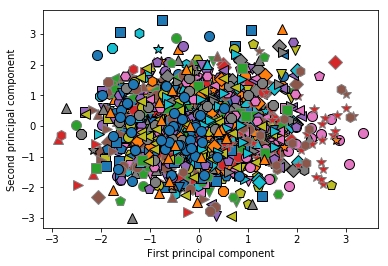

In [39]:
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

### 非負値行列因子分解(NMF)

- PCA
    - 個々の成分はデータの分散を可能な限り説明する互いに直交するものでなければいけない
- NMF
    - 組み合わされたデータを作りあげている元の成分を特定することが出来る
    - PCAよりわかりやすい成分に分解出来る

#### NMFの合成データへの適用
NMFを用いる際にはデータが全て正になるようにしなけばならない．

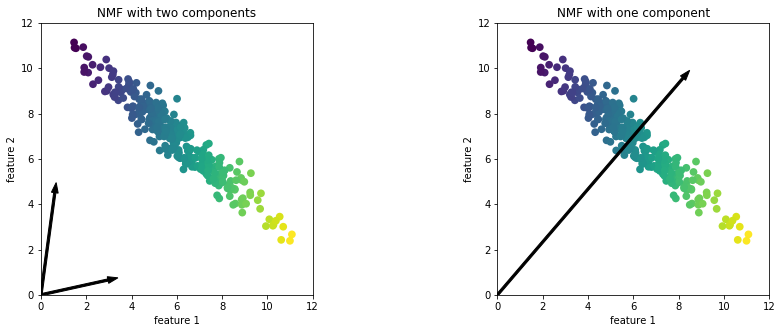

In [42]:
mglearn.plots.plot_nmf_illustration()
plt.show()

#### NMFの顔画像への適用

In [43]:
mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)
plt.show()

________________________________________________________________________________
[Memory] Calling mglearn.plot_nmf.nmf_faces...
nmf_faces(array([[ 0.535948, ...,  0.243137],
       ..., 
       [ 0.043137, ...,  0.596078]], dtype=float32), 
array([[ 0.237908, ...,  0.269281],
       ..., 
       [ 0.4     , ...,  0.254902]], dtype=float32))


KeyboardInterrupt: 

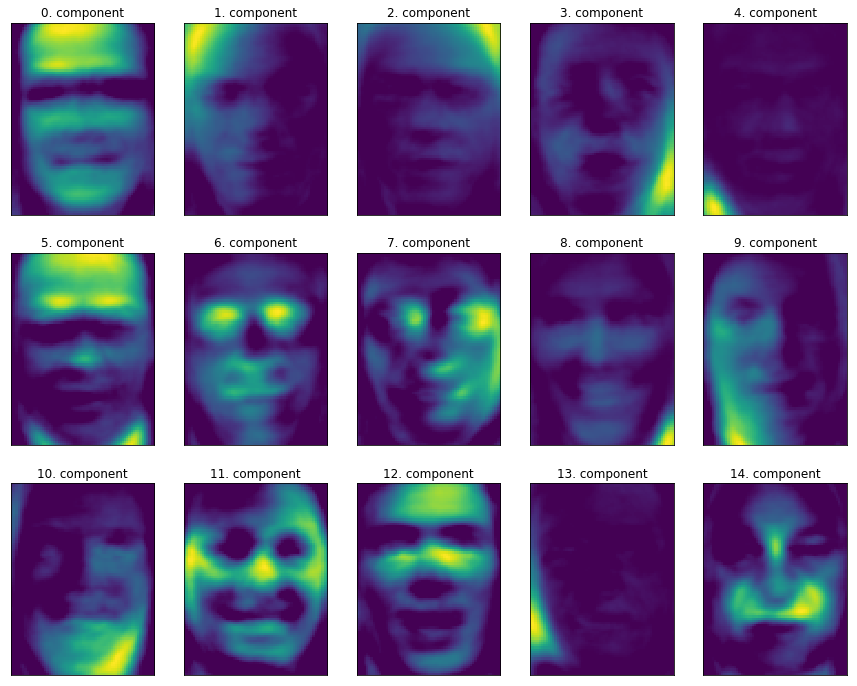

In [53]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))
    
plt.show()

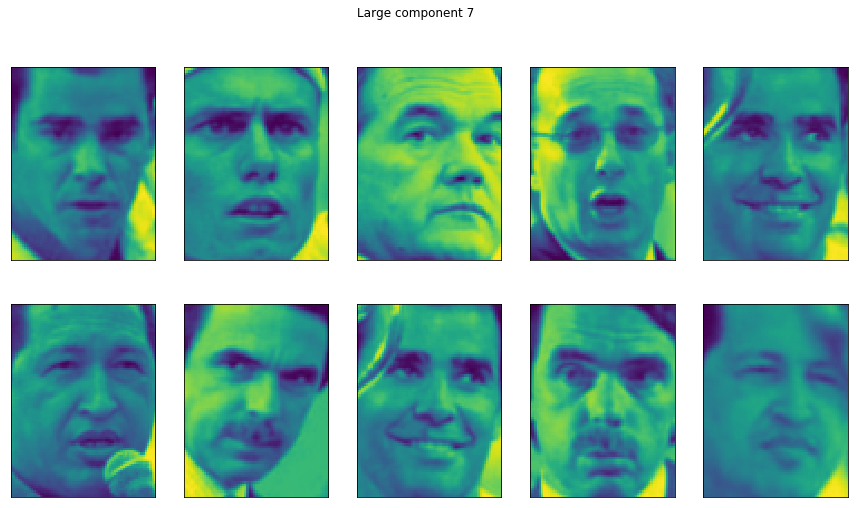

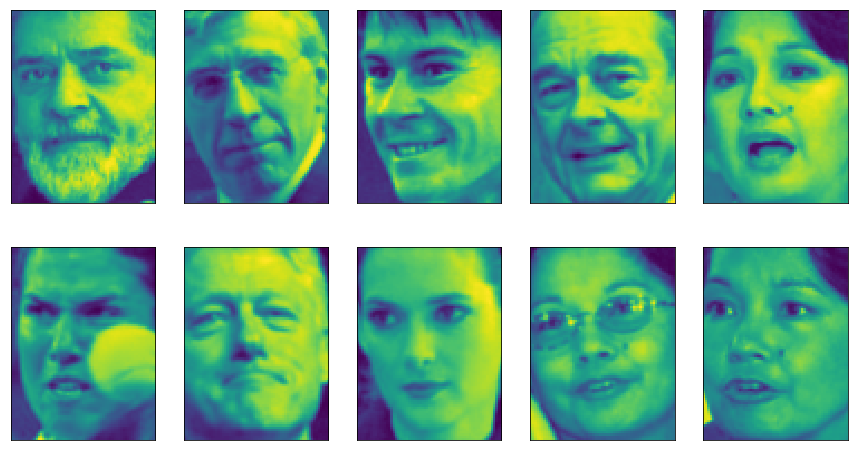

In [50]:
compn = 3
# sort by 3rd component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
fig.suptitle("Large component 3")
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

compn = 7
# sort by 7th component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig.suptitle("Large component 7")
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))
    
plt.show()

In [51]:
S = mglearn.datasets.make_signals()
plt.figure(figsize=(6, 1))
plt.plot(S, '-')
plt.xlabel("Time")
plt.ylabel("Signal")

In [54]:
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
print("Shape of measurements: {}".format(X.shape))

Shape of measurements: (2000, 100)


In [55]:
nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)
print("Recovered signal shape: {}".format(S_.shape))

Recovered signal shape: (2000, 3)


In [56]:
pca = PCA(n_components=3)
H = pca.fit_transform(X)

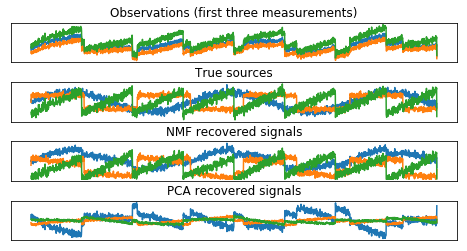

In [59]:
models = [X, S, S_, H]
names = ['Observations (first three measurements)',
         'True sources',
         'NMF recovered signals',
         'PCA recovered signals']

fig, axes = plt.subplots(4, figsize=(8, 4), gridspec_kw={'hspace': .5}, subplot_kw={'xticks': (), 'yticks': ()})

for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')
    
plt.show()

#### t-SNEを用いた多様性学習

可視化によく用いられるアルゴリズム`多様体学習アルゴリズム`，多様体学習アルゴリズムは主に可視化に用いられ，殆どの場合3以上の新しい特徴量を生成するように利用することはない．

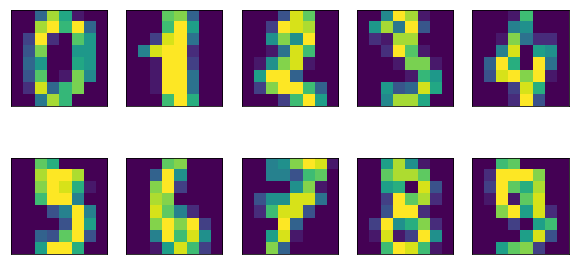

In [62]:
from sklearn.datasets import load_digits
digits = load_digits()

fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks':(), 'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

plt.show()

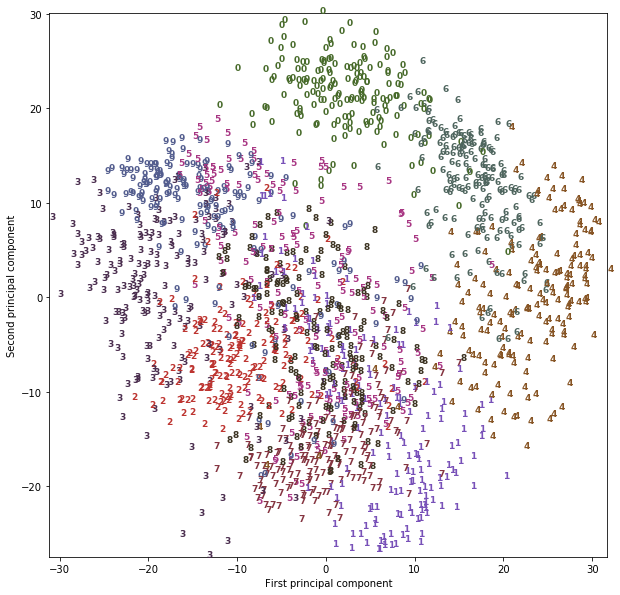

In [63]:
pca = PCA(n_components=2)
pca.fit(digits.data)

digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())
for i in range(len(digits.data)):

    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

plt.show()

In [64]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
digits_tsne = tsne.fit_transform(digits.data)

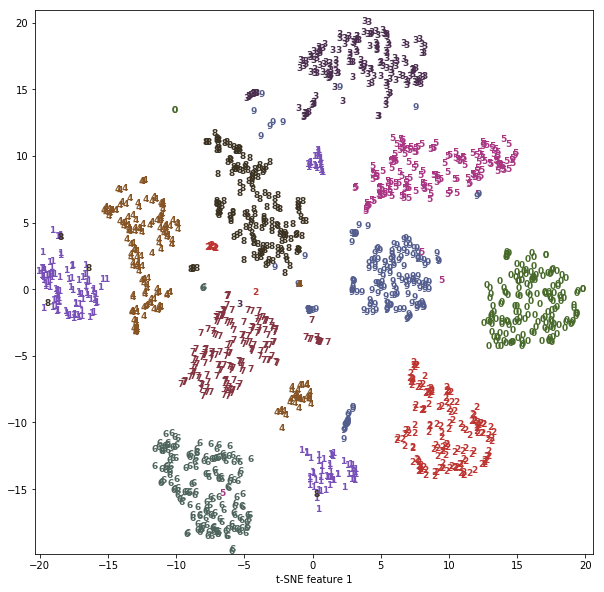

In [65]:
plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits.data)):
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE feature 0")
plt.xlabel("t-SNE feature 1")
plt.show()